Basic pseudotime analysis
=========================

The objective of this notebook is to learn how to perform tree inference from single cell data, starting from a count matrix.
Significant features that significantly changes along the tree will then be extracted and clustered.

## Importing modules and basic settings

In [1]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import palantir
import scFates as scf
%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6), facecolor='white')

## Load data and run pipeline from Palantir

This cell follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) with some slight changes. Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df=sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)
tsne = palantir.utils.run_tsne(ms_data,n_jobs=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [4]:
adata.obsm["X_palantir"]=ms_data.values
adata.obsm["X_tsne"]=tsne.values

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


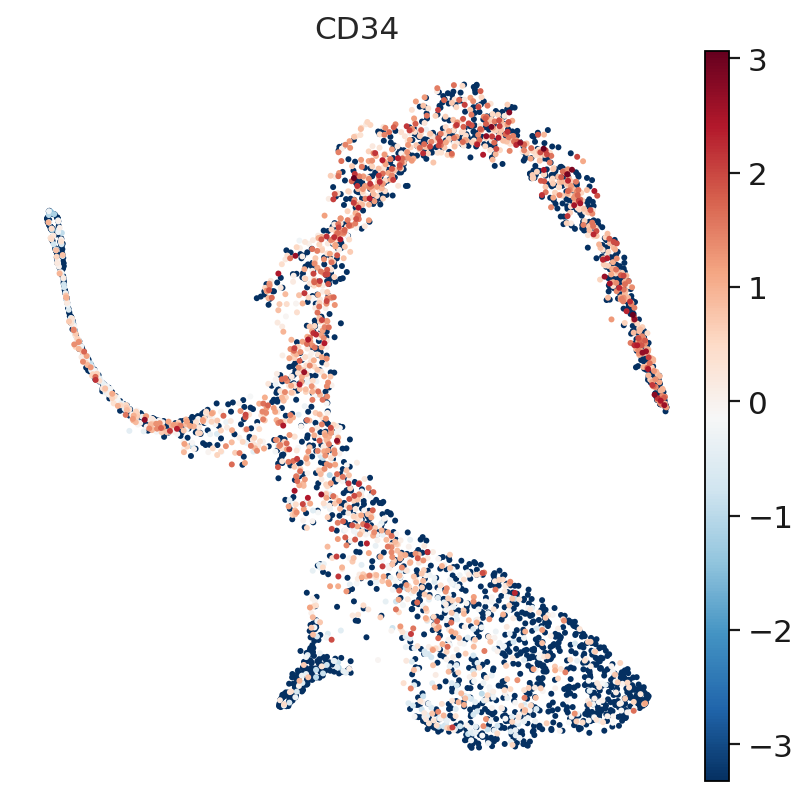

In [5]:
sc.pl.tsne(adata,color="CD34",color_map="RdBu_r")

## Learn tree using ElPiGraph algorithm

We will infer a principal tree on the multiscale diffusion space generated by Palantir. Any dimensionality reduction in `.obsm` can be selected using `use_rep` parameter. The method for tree learning is defined by `method` parameter: Here we choose ElPiGraph ('epg').  

In [6]:
scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="gpu",seed=1,epg_lambda= .05)

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.05
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  4142  points and  3  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2||50	0.0077	50	49	44	2	0	0	0.0023	0.0022	0.9869	0.9876	0.0053	0.0001	0.004	0.2006	0


12.9076  seconds elapsed
    finished (0:00:13) --> added 
    'epg', dictionnary containing inferred elastic tree generated from elpigraph (adata.uns)
    'tree/B', adjacency matrix of the principal points (adata.uns)
    'tree/R', soft assignment (a

## Projecting the tree on the tsne computed from Palantir

By default the plot function will annotate automatically the tips and the forks ids.

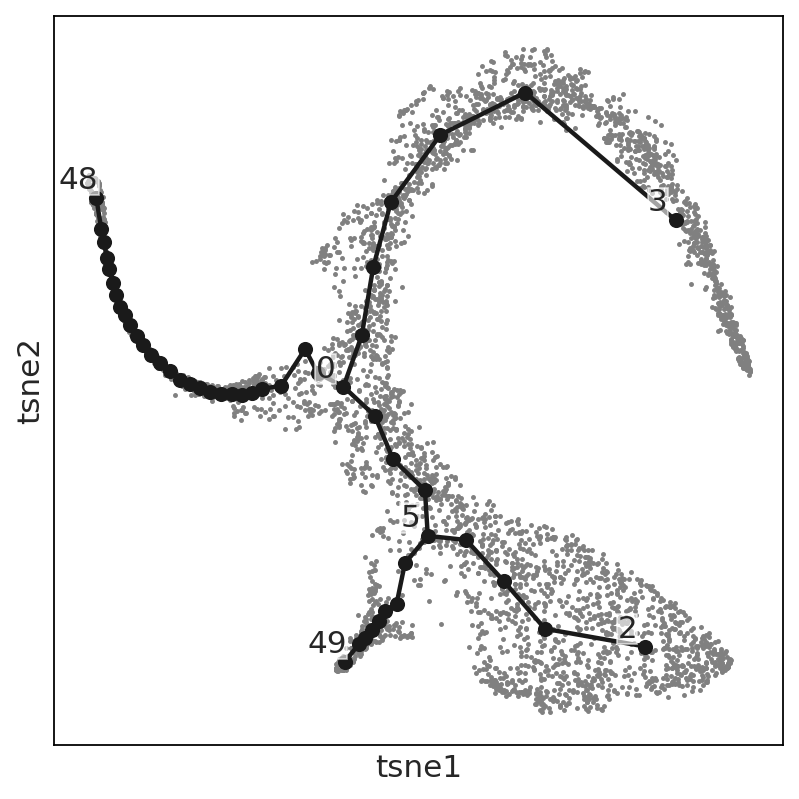

In [7]:
scf.pl.tree(adata,basis="tsne")

## Selecting a root and computing pseudotime

Using CD34 marker, we can confidently tell that the tip 3 is the root.

In [8]:
scf.tl.root(adata,3)

root selected --> added
    'tree/root', selected root (adata.uns)
    'tree/pp_info', for each PP, its distance vs root and segment assignment (adata.uns)
    'tree/pp_seg', segments network information (adata.uns)


Having the root selected, we can now project the cells onto the tree and compute the pseudotime value for each of them.

In [9]:
scf.tl.pseudotime(adata)

projecting cells onto the principal tree
    finished (0:00:00) --> added
    'edge', assigned edge (adata.obs)
    't', pseudotime value (adata.obs)
    'seg', segment of the tree where the cell is assigned to (adata.obs)
    'milestones', milestones assigned to (adata.obs)
    'tree/pseudotime_list', list of cell projection from all mappings (adata.uns)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


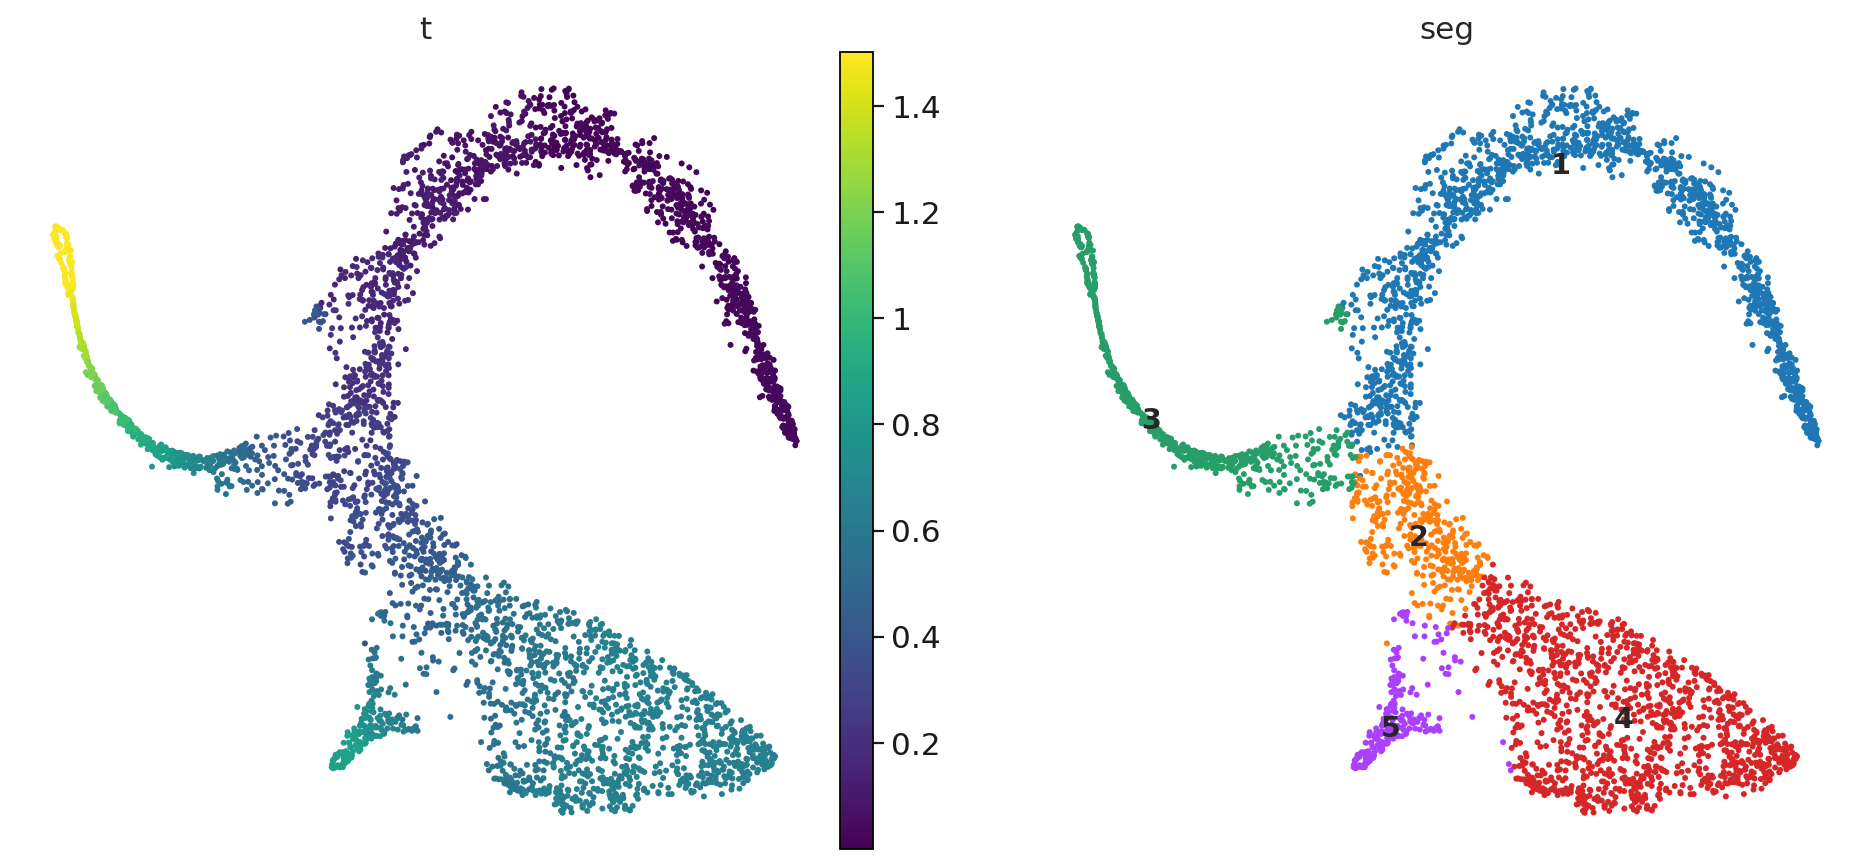

In [10]:
sc.pl.scatter(adata,basis="tsne", color=['t','seg'], legend_loc='on data',color_map="viridis")

## Test and fit associated features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [11]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the tree
    mapping 0: 100%|██████████| 16106/16106 [02:57<00:00, 90.85it/s] 
    found 3205 significant features (0:02:58) --> added
    'p_val' values from statistical test (adata.var)
    'fdr' corrected values from multiple testing (adata.var)
    'st' proportion of mapping in which feature is significant (adata.var)
    'A' amplitue of change of tested feature (adata.var)
    'tree/stat_assoc_list', list of fitted features on the tree for all mappings (adata.uns)


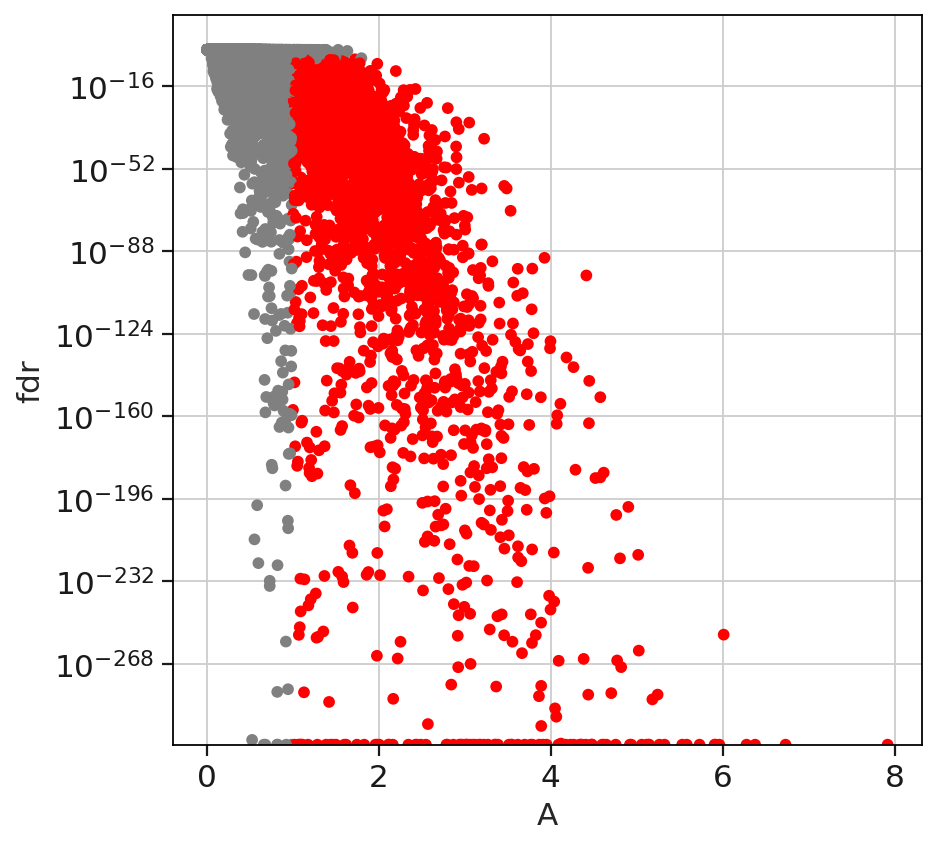

In [12]:
scf.pl.test_association(adata)

We can now fit the significant genes.

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those!

</div>

In [13]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the tree
    mapping 0: 100%|██████████| 3205/3205 [01:40<00:00, 31.75it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:50) --> added
    'fitted', fitted features on the tree for all mappings (adata.layers)


## Cluster and plot fitted features

In [14]:
scf.tl.cluster(adata,knn=300,metric="correlation",device="gpu")

    clustering using grapheno
Finding 300 nearest neighbors using correlation metric and brute algorithm...
Neighbors computed in 1.7196719646453857 seconds...
Computing Jaccard similarity...
jaccard graph constructed in 0.03576159477233887 seconds...
Running Louvain modularity optimization...
grapheno completed in 1.9070940017700195 seconds...
Communities detected: 6
Modularity: 0.5585402250289917
    finished (0:00:05) --> added
    'fit_clusters', cluster assignments for features (adata.var)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


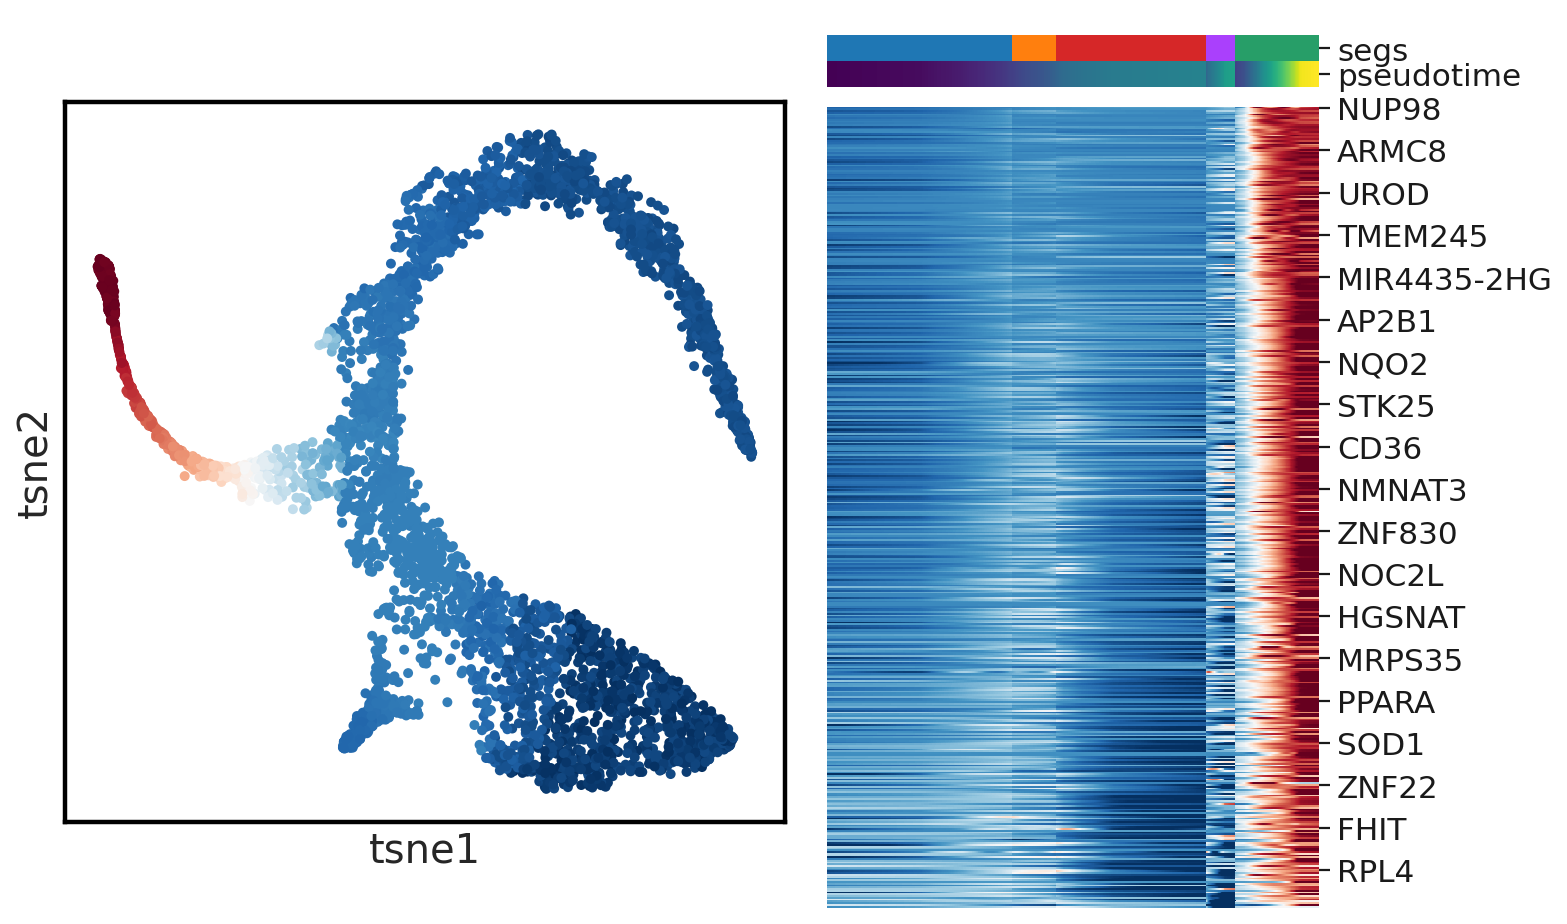

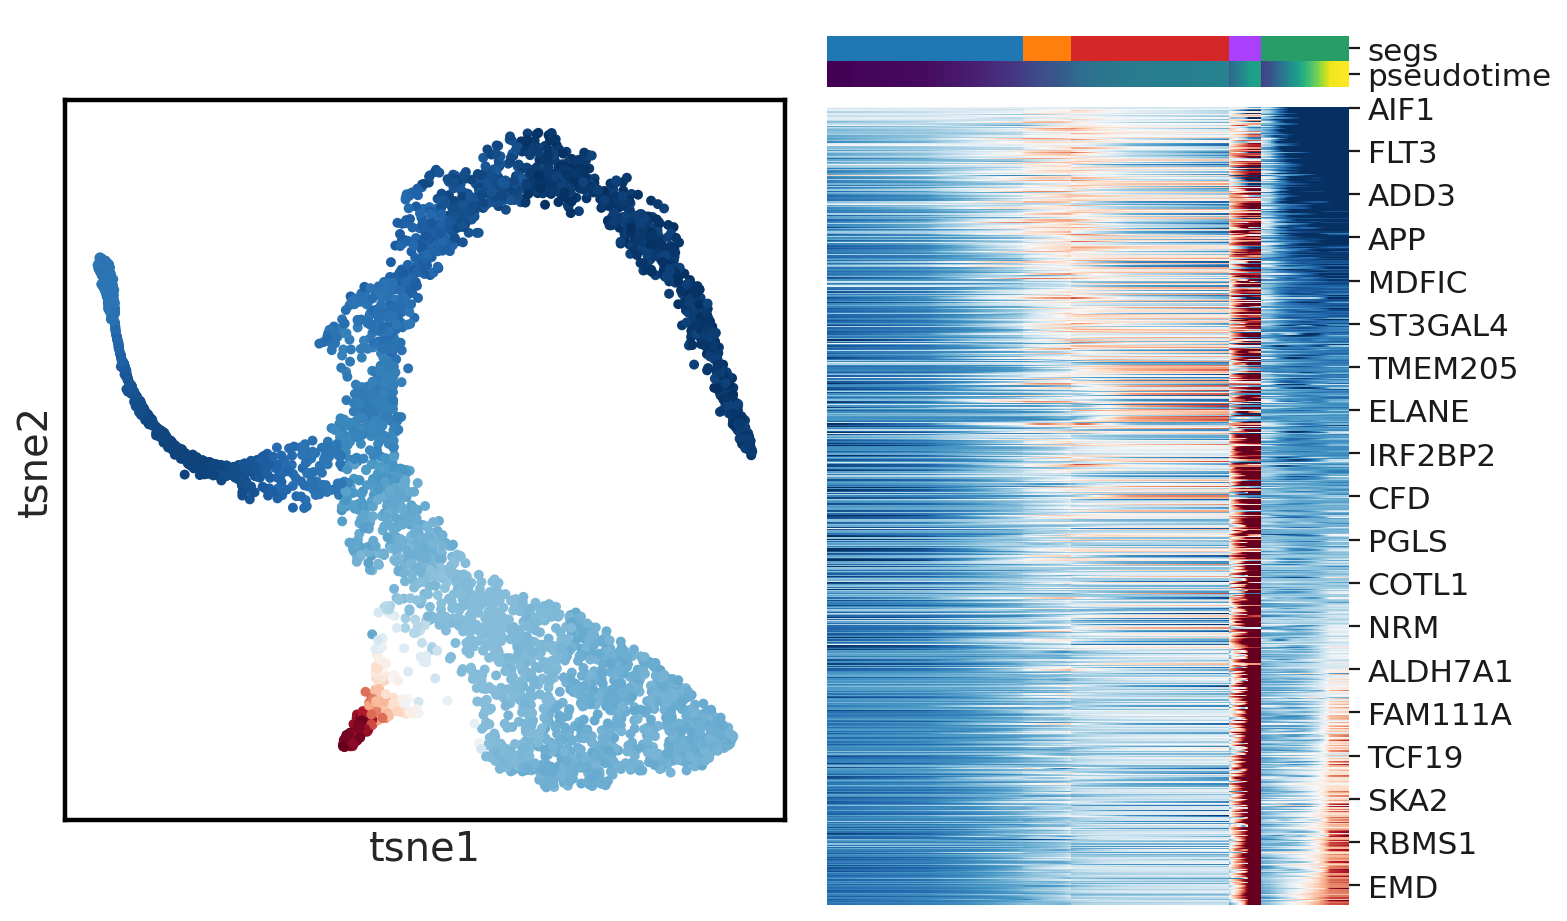

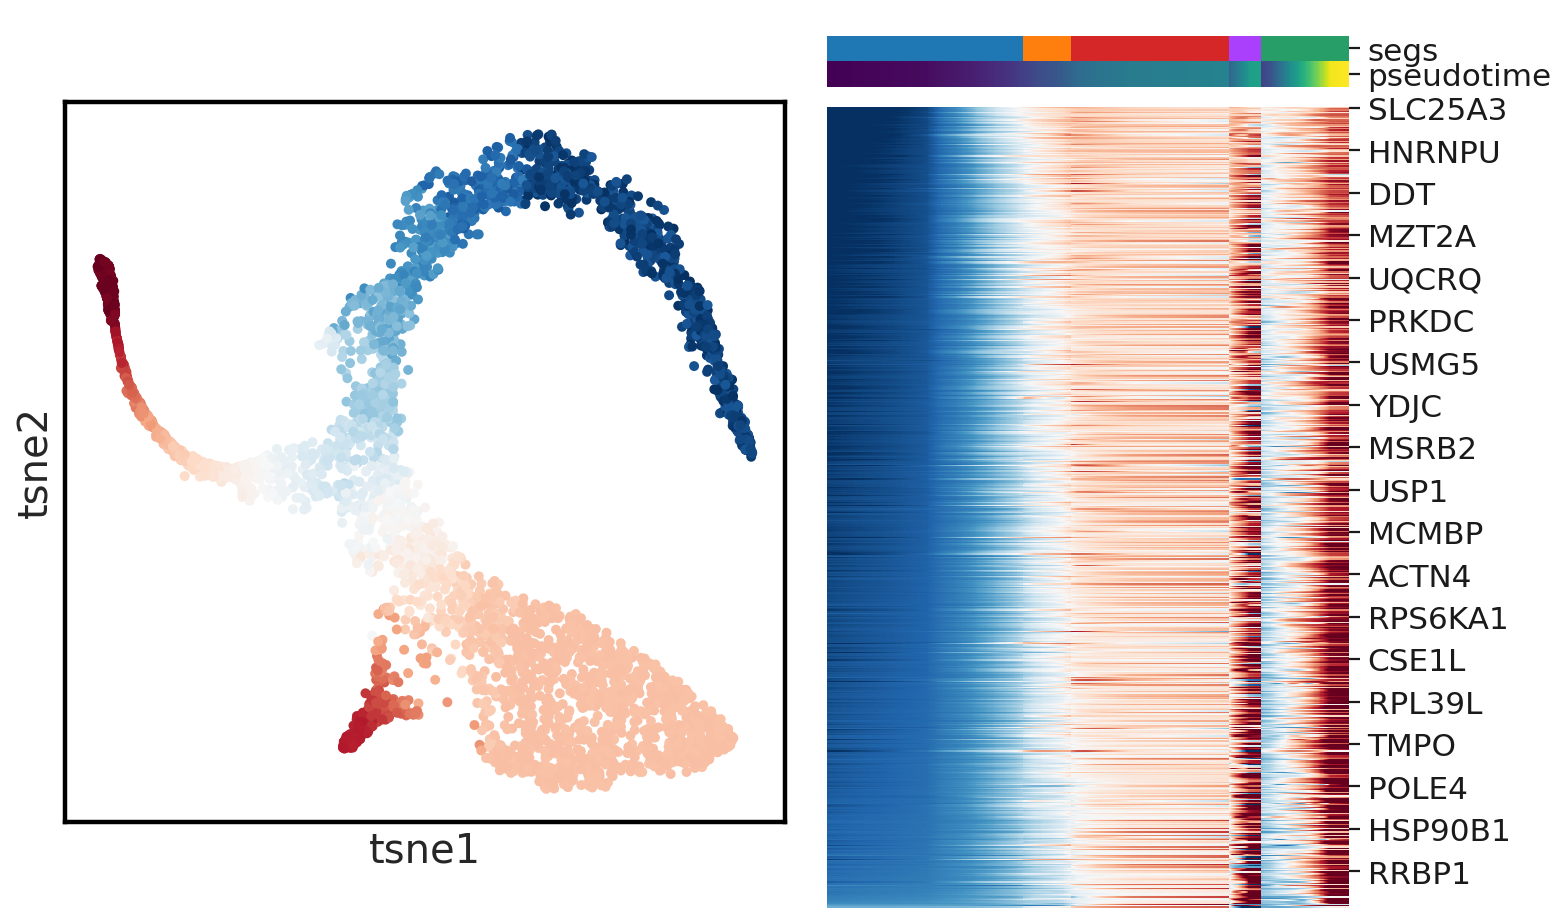

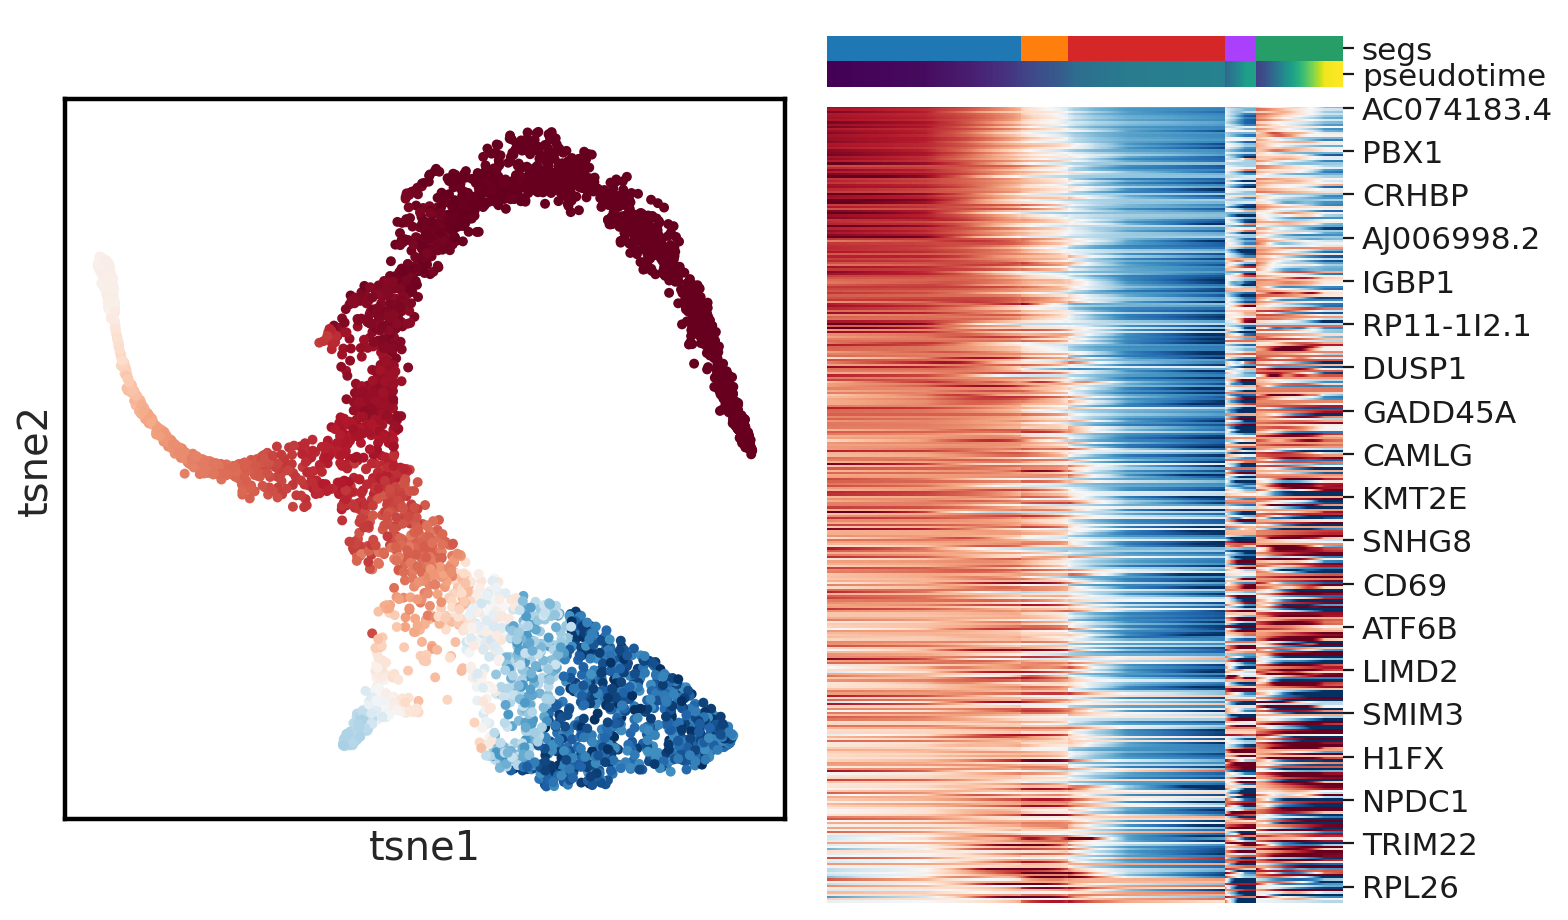

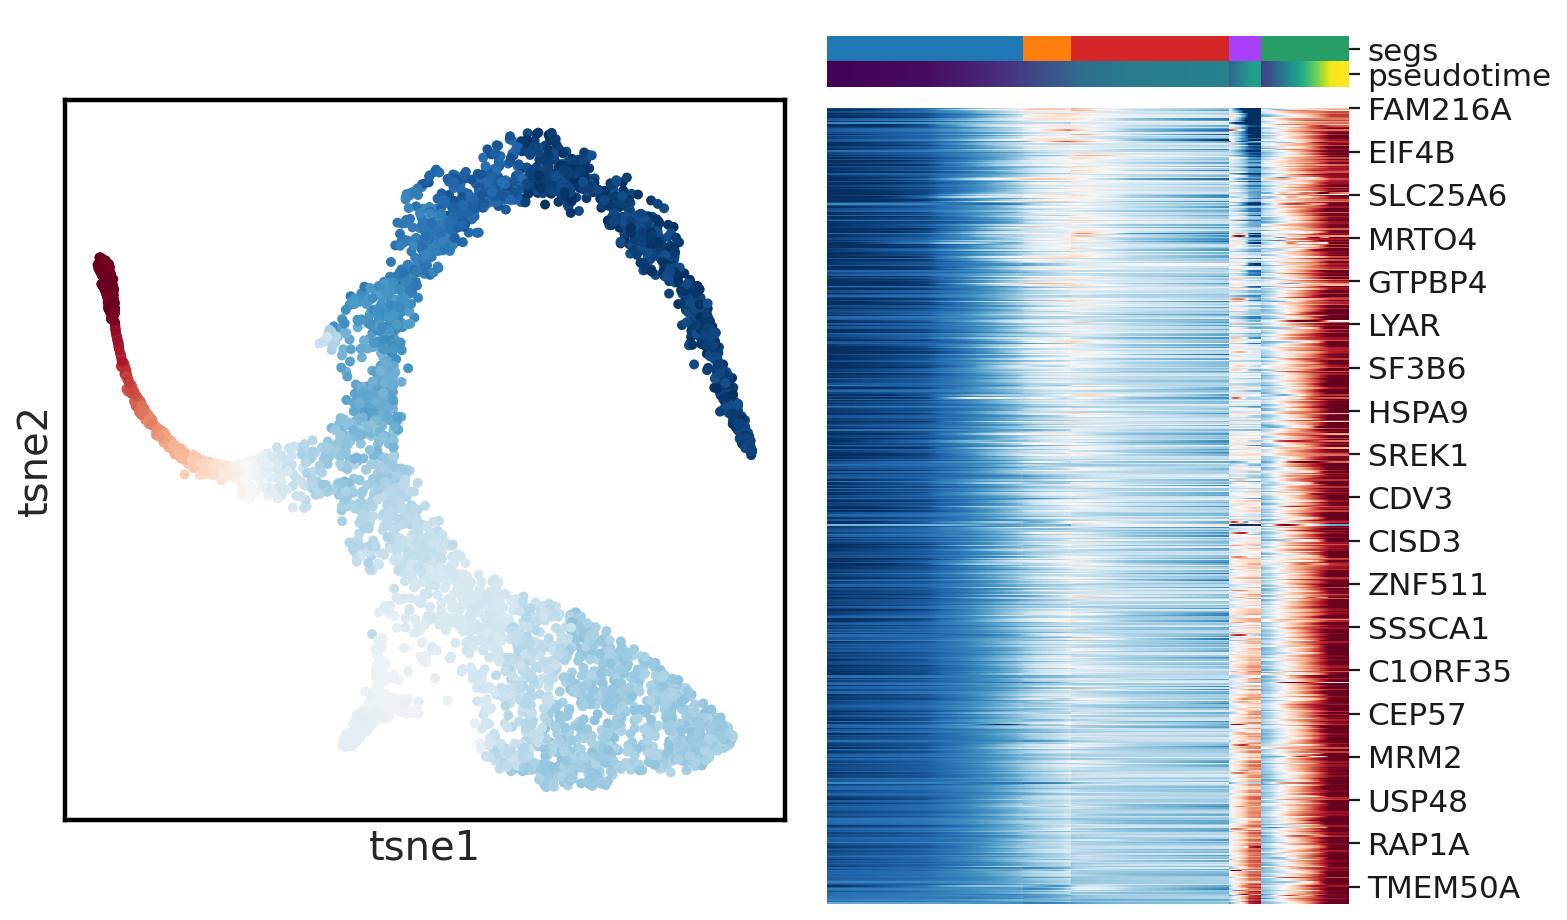

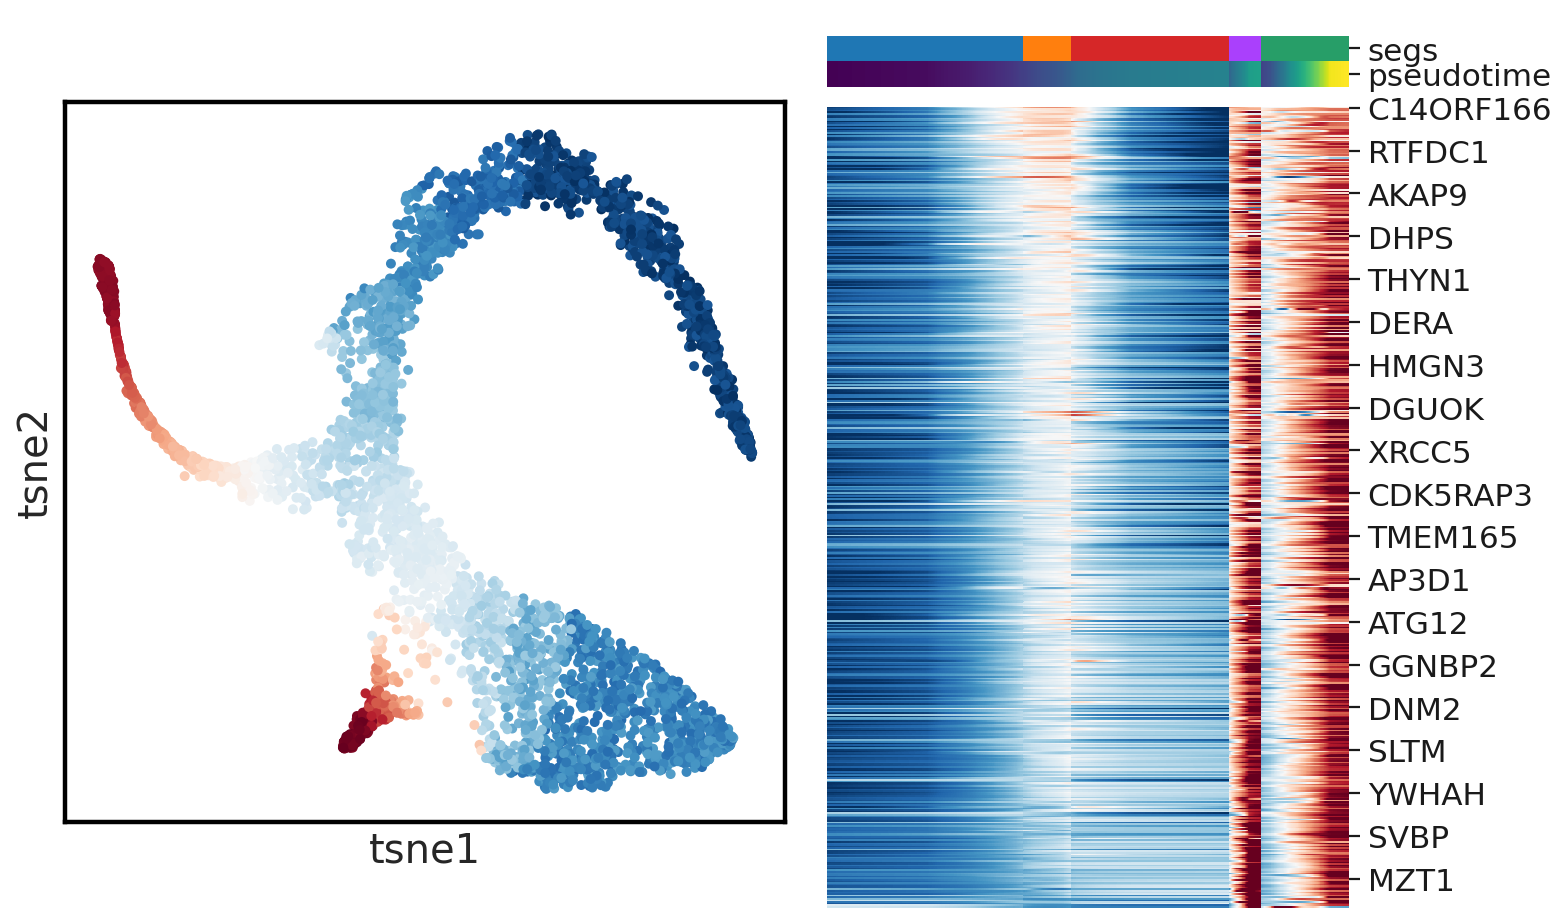

In [15]:
for c in pd.Series(adata.var["fit_clusters"]).unique():
    scf.pl.cluster(adata,clu=c,basis="tsne",figsize=(10,6))

## Plot single features

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


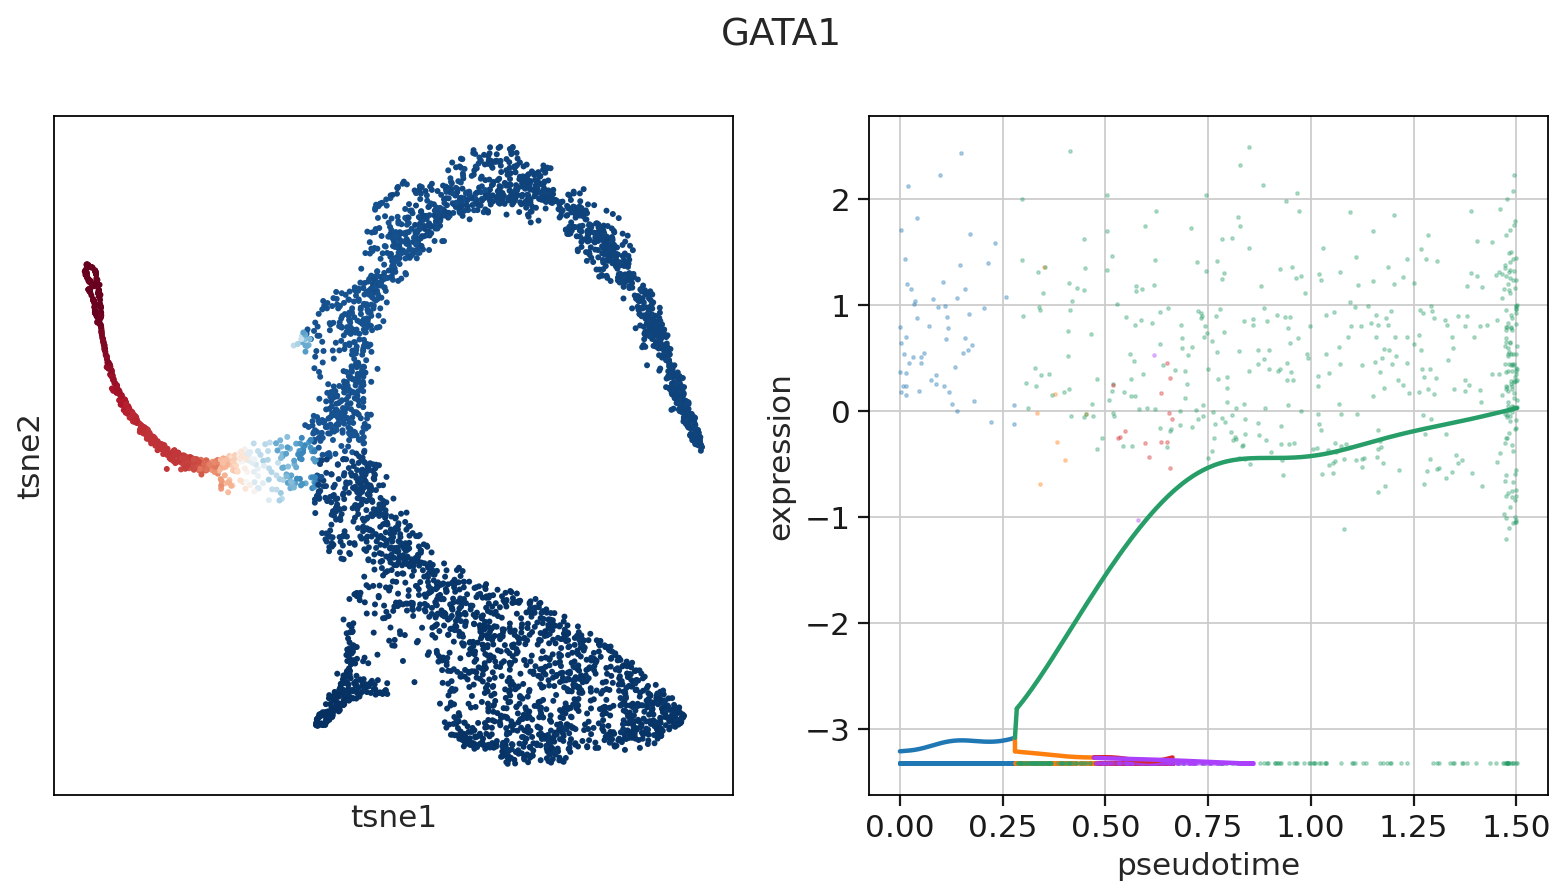

In [16]:
scf.pl.single_trend(adata,feature="GATA1",basis="tsne")